In [156]:
%matplotlib inline
import os
import pandas as pd

from matplotlib import pyplot as plt
from ObjectDetectionMetrics.utils import *
from ObjectDetectionMetrics.BoundingBox import *
from ObjectDetectionMetrics.BoundingBoxes import *
from ObjectDetectionMetrics.Evaluator import *

In [157]:
class_label_file = "./OpenImagesDataset/filteredLabels.csv"
labels = pd.read_csv(class_label_file)

gt_bbox_file = "./OpenImagesDataset/test/test-filtered-bbox.csv"

gt_bboxes = pd.read_csv(gt_bbox_file, escapechar='"')
gt_bboxes = pd.merge(gt_bboxes, labels, on="LabelName")

In [158]:
TEST_DIR = "../../Mestrado/OpenImagesDataset/test"
extensions = ['jpg','jpeg']
img_ids = [file.split(".")[0] for file in os.listdir(TEST_DIR) if any(file.endswith(ext) for ext in extensions)]

gt_bboxes = gt_bboxes[gt_bboxes.ImageID.isin(img_ids)]

In [159]:
#MODEL = "frozen-mobilenet-oid-7869"
#MODEL = "frozen-mobilenet-fpn-coco-5981"
#MODEL = "frozen-resnet101-oid-8466"
MODEL = "frozen-faster-rcnn-oid-1081"

detections_csv = TEST_DIR + f"_detections_{MODEL}.csv"
detections = pd.read_csv(detections_csv)

In [160]:
def get_bounding_boxes(gt_bboxes, detections):
    allBoundingBoxes = BoundingBoxes()

    for _, row in gt_bboxes.iterrows():
        bb = BoundingBox(row.ImageID, row.ClassName, row.XMin, row.YMin, row.XMax, row.YMax, format=BBFormat.XYX2Y2)
        allBoundingBoxes.addBoundingBox(bb)

    for _, row in detections.iterrows():
        if pd.isna(row.ClassName): continue

        bb = BoundingBox(row.ImageID, row.ClassName, row.XMin, row.YMin, row.XMax, row.YMax,
                         format=BBFormat.XYX2Y2, bbType=BBType.Detected, classConfidence=row.Confidence)
        allBoundingBoxes.addBoundingBox(bb)
        
    return allBoundingBoxes
    
allBoundingBoxes = get_bounding_boxes(gt_bboxes, detections)

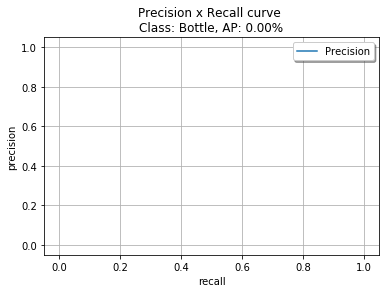

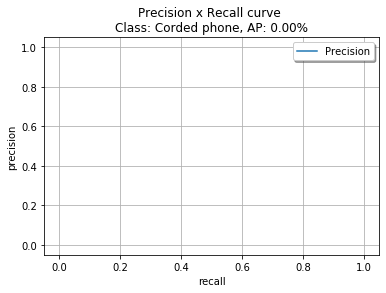

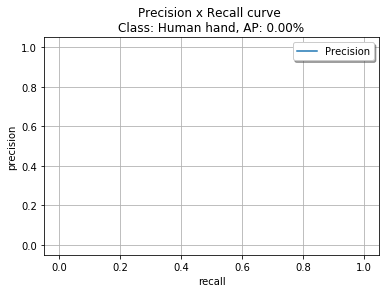

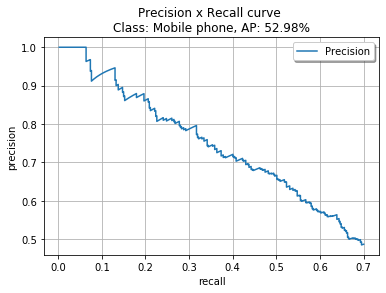

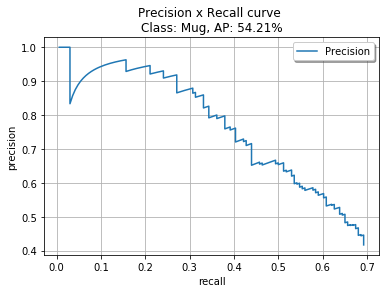

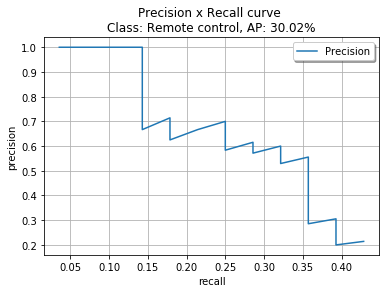

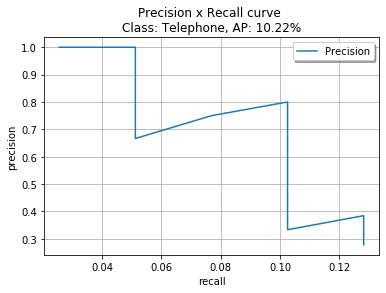

In [161]:
evaluator = Evaluator()

results = evaluator.PlotPrecisionRecallCurve(allBoundingBoxes, IOUThreshold=0.5, showAP=True, showInterpolatedPrecision=False)

In [162]:
bla = ((r['class'], r['AP'], r['total TP'], r['total FP'], r['total positives']) for r in results)
df = pd.DataFrame(bla, columns=["ClassName", "AP", "TP", "FP", "GTs"])
mAP = df.AP.mean()
print(f"mAP: {mAP*100:.2f}%")
df

mAP: 21.06%


,ClassName,AP,TP,FP,GTs
0,Bottle,0.000000,0.0,0.0,1102
1,Corded phone,0.000000,0.0,0.0,18
2,Human hand,0.000000,0.0,0.0,13245
3,Mobile phone,0.529801,285.0,300.0,407
4,Mug,0.542073,115.0,161.0,166
5,Remote control,0.300181,12.0,44.0,28
6,Telephone,0.102170,5.0,13.0,39


In [163]:
def plot_precision_recall_on_axis(results_dict, axis):
    classId = results_dict['class']
    precision = results_dict['precision']
    recall = results_dict['recall']
    average_precision = results_dict['AP']
    mpre = results_dict['interpolated precision']
    mrec = results_dict['interpolated recall']
    npos = results_dict['total positives']
    total_tp = results_dict['total TP']
    total_fp = results_dict['total FP']
    
    axis.plot(recall, precision, label='Precision')
    axis.set_xlabel('recall')
    axis.set_ylabel('precision')
    
    ap_str = "{0:.2f}%".format(average_precision * 100)
    axis.set_title('Class: %s, AP: %s' % (str(classId), ap_str)) #Precision x Recall curve \n
    
    

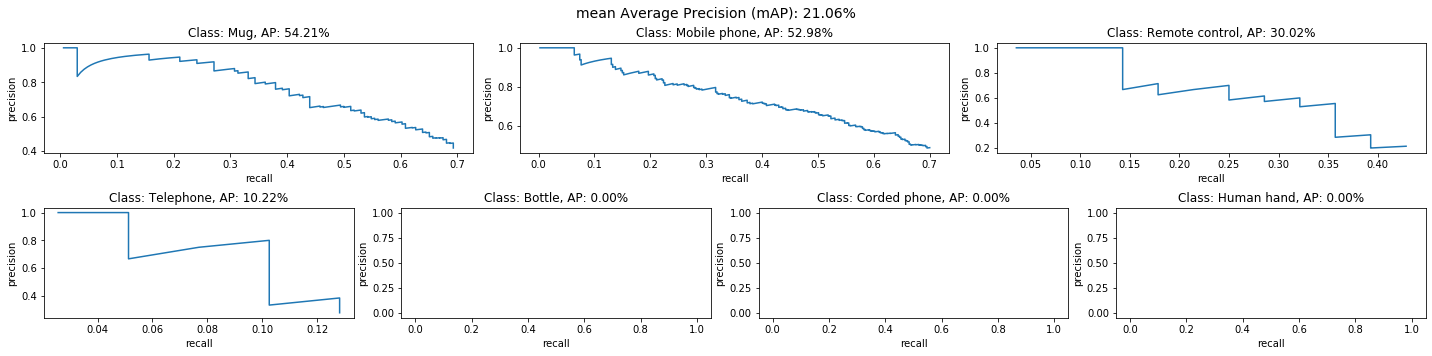

In [164]:
def plot_results(results):
    fig = plt.figure(figsize=(20,5))

    axes = (plt.subplot2grid(shape=(2, 12), loc=l, colspan=s, fig=fig) 
            for l,s in zip([(0,0),(0,4),(0,8), (1,0),(1,3),(1,6),(1,9)], [4,4,4,3,3,3,3]))

    r = sorted(results, key= lambda x : x['AP'], reverse=True)
    for result, ax in zip(r, axes):
        plot_precision_recall_on_axis(result, ax)

    plt.suptitle(f"mean Average Precision (mAP): {mAP*100:.2f}%", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    
    return fig
    
fig = plot_results(results)

In [165]:
#IMG_DIR = "path/to/save/images/to"
IMG_DIR = f"../../Mestrado/Imagens/{MODEL}"
if not os.path.exists(IMG_DIR):
        os.makedirs(IMG_DIR)

fig.savefig(f"{IMG_DIR}/PrecisionRecalls_{MODEL}.png")

In [166]:
def box_area(row):
    return (row.XMax - row.XMin) * (row.YMax - row.YMin)

In [167]:
gt_bboxes["BoxArea"] = gt_bboxes.apply(lambda row: box_area (row),axis=1)
idx = gt_bboxes.groupby(["ImageID", "LabelName"])['BoxArea'].idxmax()
grouped_gt_bboxes = gt_bboxes.loc[idx]

In [168]:
detections["BoxArea"] = detections.apply(lambda row: box_area (row),axis=1)
idx = detections.groupby(["ImageID", "ClassName"])['BoxArea'].idxmax()
grouped_detections = detections.loc[idx]

In [169]:
grouped_bboxes = get_bounding_boxes(grouped_gt_bboxes, grouped_detections)
grouped_evaluator = Evaluator()

grouped_results = grouped_evaluator.GetPascalVOCMetrics(allBoundingBoxes, IOUThreshold=0.5)#, showAP=True, showInterpolatedPrecision=False)

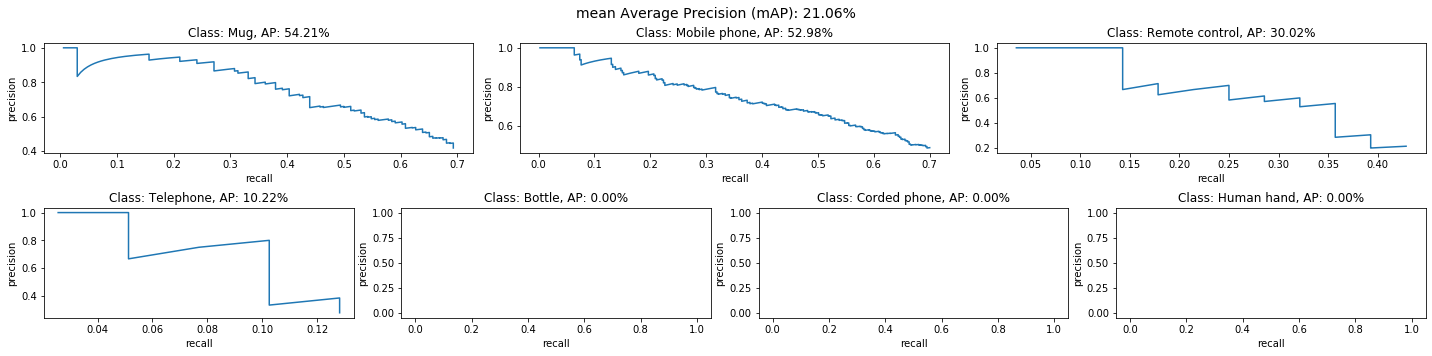

In [170]:
grouped_fig = plot_results(grouped_results)